In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression

from sklearn.linear_model import Lasso
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
train = pd.read_csv('train.csv')
stores = pd.read_csv('stores.csv')
features = pd.read_csv('features.csv')
test = pd.read_csv('test.csv')

In [3]:
merge_train = train.merge(stores, how='left').merge(features, how='left')
merge_test = test.merge(stores, how='left').merge(features, how='left')
# Extracting Date, Month, Quarter and Week columns from the week column


In [4]:
def split_date(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df.Date.dt.year
    df['Month'] = df.Date.dt.month
    df['Day'] = df.Date.dt.day
    df['Quarter'] = df.Date.dt.quarter
    df['WeekOfYear'] = (df.Date.dt.isocalendar().week) * 1.0
split_date(merge_train)
split_date(merge_test)

In [5]:
df = merge_train.isnull().mean() * 100
print(df)

Store             0.0
Dept              0.0
Date              0.0
Weekly_Sales      0.0
IsHoliday         0.0
Type              0.0
Size              0.0
Temperature     100.0
Fuel_Price      100.0
MarkDown1       100.0
MarkDown2       100.0
MarkDown3       100.0
MarkDown4       100.0
MarkDown5       100.0
CPI             100.0
Unemployment    100.0
Year              0.0
Month             0.0
Day               0.0
Quarter           0.0
WeekOfYear        0.0
dtype: float64


In [6]:
merge_train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,...,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Year,Month,Day,Quarter,WeekOfYear
0,1,1,2010-02-05,24924.50,False,A,151315,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2010,2,5,1,5.0
1,1,1,2010-02-12,46039.49,True,A,151315,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2010,2,12,1,6.0
2,1,1,2010-02-19,41595.55,False,A,151315,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2010,2,19,1,7.0
3,1,1,2010-02-26,19403.54,False,A,151315,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2010,2,26,1,8.0
4,1,1,2010-03-05,21827.90,False,A,151315,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2010,3,5,1,9.0


In [7]:
# Dropping columns that are not required for modeling, including 'MarkDown2' and 'MarkDown3'
cols_to_drop = ['Date', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2','Type', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'Month','Day']
merge_train = merge_train.drop([col for col in cols_to_drop if col in merge_train.columns], axis=1)
merge_test = merge_test.drop([col for col in cols_to_drop if col in merge_test.columns], axis=1)

In [8]:
merge_train.head()

,Store,Dept,Weekly_Sales,IsHoliday,Size,Year,Quarter,WeekOfYear
0,1,1,24924.50,False,151315,2010,1,5.0
1,1,1,46039.49,True,151315,2010,1,6.0
2,1,1,41595.55,False,151315,2010,1,7.0
3,1,1,19403.54,False,151315,2010,1,8.0
4,1,1,21827.90,False,151315,2010,1,9.0


In [9]:
input_column = merge_train.columns.to_list()
input_column.remove('Weekly_Sales')

target_column = 'Weekly_Sales'
inputs = merge_train[input_column].copy()
targets = merge_train[target_column].copy()

In [10]:
print(input_column)
inputs.head()

['Store', 'Dept', 'IsHoliday', 'Size', 'Year', 'Quarter', 'WeekOfYear']


,Store,Dept,IsHoliday,Size,Year,Quarter,WeekOfYear
0,1,1,False,151315,2010,1,5.0
1,1,1,True,151315,2010,1,6.0
2,1,1,False,151315,2010,1,7.0
3,1,1,False,151315,2010,1,8.0
4,1,1,False,151315,2010,1,9.0


In [11]:
minmax_scaler = MinMaxScaler().fit(merge_train[input_column])

In [12]:
inputs[input_column] = minmax_scaler.transform(inputs[input_column])
merge_test[input_column] = minmax_scaler.transform(merge_test[input_column])


In [13]:
train_inputs, val_inputs, train_targets, val_targets = train_test_split(
    inputs,
    targets,
    random_state=42,
    shuffle=True
)

In [14]:
# Training & Validation Sets
from sklearn.model_selection import train_test_split

train_inputs, val_inputs, train_targets, val_targets = train_test_split(
    inputs,
    targets,
             # specify validation size (20% of the data)
    random_state=42,       # ensures reproducibility
    shuffle=True,          # shuffles the data before splitting
   # stratify=targets       # ensures proportional class distribution (only for classification)
)


# WMAE Function Create
def WMAE(df, targets, predictions):
    weights = df['IsHoliday'].apply(lambda x: 5 if x else 1)
    return np.round(np.sum(weights * np.abs(targets - predictions)) / np.sum(weights), 2)

In [15]:
rf1 = RandomForestRegressor(n_jobs=-1, random_state=42)
# Fit the model
rf1.fit(train_inputs, train_targets)
rf1_train_preds = rf1.predict(train_inputs)
# Compute WMAE on training data
rf1_train_wmae = WMAE(train_inputs, train_targets, rf1_train_preds)
rf1_val_preds = rf1.predict(val_inputs)
# Compute WMAE on validation data
rf1_val_wmae = WMAE(val_inputs, val_targets, rf1_val_preds)
print('WMAE Validation Datatset: {}.'.format(rf1_val_wmae))

WMAE Validation Datatset: 1572.72.


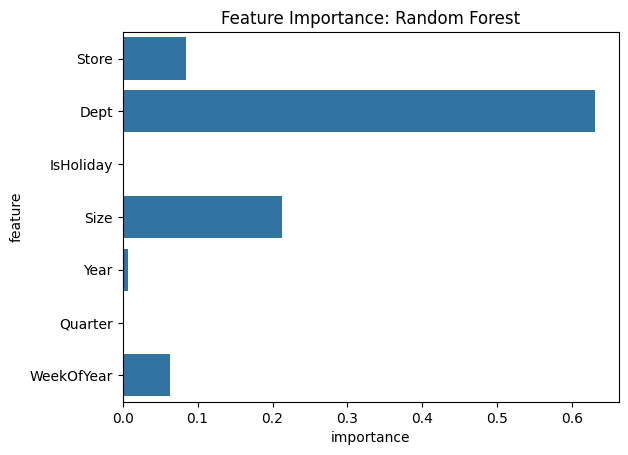

In [16]:
importance_df = pd.DataFrame({
'feature': train_inputs.columns,
'importance': rf1.feature_importances_})
plt.title('Feature Importance: Random Forest')
sns.barplot(data=importance_df, x='importance', y='feature')
plt.show()

In [17]:
def test_parameters_rf(**params):
    model = RandomForestRegressor(random_state=42, n_jobs=-1, **params).fit(train_inputs, train_targets)
    trainWMAE = WMAE(merge_train.loc[train_inputs.index], train_targets, model.predict(train_inputs))
    valWMAE = WMAE(merge_train.loc[val_inputs.index], val_targets, model.predict(val_inputs))
    return trainWMAE, valWMAE

In [18]:
#def test_parameters_rf(**params):
 #   model = RandomForestRegressor(random_state=42, n_jobs=-1, **params).fit(train_inputs, trainWMAE = WMAE(train_inputs, train_targets, model.predict(train_inputs))
#valWMAE = WMAE(val_inputs, val_targets, model.predict(val_inputs))
#return trainWMAE, valWMAE

In [19]:
def test_parameters_and_plot(param_name, param_values):
    train_errors, val_errors = [], []
    for value in param_values:
        params = {param_name: value}
        trainWMAE, valWMAE = test_parameters_rf(**params)
        train_errors.append(trainWMAE)
        val_errors.append(valWMAE)

In [20]:
# Create the model
from sklearn.ensemble import RandomForestRegressor

# Create the model with corrected parameter
randomforest1 = RandomForestRegressor(
    n_jobs=-1,
    max_depth=10,
    n_estimators=50,
    min_samples_split=2,   # Replace with your intended value
    max_features=6,
    random_state=42
)



In [21]:
randomforest1.fit(train_inputs, train_targets)

,n_estimators,50
,criterion,'squared_error'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,6
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [22]:
rf1_train_preds = randomforest1.predict(train_inputs)

In [23]:
print(train_inputs)

           Store      Dept  IsHoliday      Size  Year   Quarter  WeekOfYear
150504  0.340909  0.183673        0.0  0.120825   0.5  1.000000    0.980392
216043  0.477273  0.928571        0.0  0.458367   0.5  0.333333    0.411765
295382  0.681818  0.112245        1.0  0.914088   1.0  0.000000    0.098039
279744  0.636364  0.204082        0.0  0.318073   0.0  0.666667    0.490196
377848  0.886364  0.591837        0.0  0.650663   0.5  0.333333    0.313725
...          ...       ...        ...       ...   ...       ...         ...
259178  0.590909  0.173469        0.0  0.916437   1.0  1.000000    0.803922
365838  0.863636  0.357143        0.0  0.807775   0.0  0.333333    0.372549
131932  0.295455  0.285714        0.0  0.898651   0.0  0.333333    0.313725
146867  0.318182  0.908163        0.0  0.480993   0.5  0.666667    0.490196
121958  0.272727  0.316327        0.0  1.000000   0.5  1.000000    0.784314

[316177 rows x 7 columns]


In [24]:
# Compute WMAE on training data
rf1_train_wmae = WMAE(train_inputs, train_targets, rf1_train_preds)
rf1_val_preds = rf1.predict(val_inputs)


In [25]:
# Compute WMAE on validation data
rf1_val_wmae = WMAE(val_inputs, val_targets, rf1_val_preds)
print('WMAE Validation Datatset (Tuned Parameters): {}'.format(rf1_val_wmae))


WMAE Validation Datatset (Tuned Parameters): 1572.72


In [26]:
from sklearn.metrics import r2_score

# Calculate R2 score for validation set
r2_val = r2_score(val_targets, rf1_val_preds)
print("R2 score on validation set:", r2_val)

R2 score on validation set: 0.9741385044095475


In [27]:
import joblib

# Save the trained RandomForestRegressor model
joblib.dump(randomforest1, 'randomforest1_model.pkl')

# Save the fitted MinMaxScaler
joblib.dump(minmax_scaler, 'minmax_scaler.pkl')

['minmax_scaler.pkl']

In [28]:
merge_train.head()

,Store,Dept,Weekly_Sales,IsHoliday,Size,Year,Quarter,WeekOfYear
0,1,1,24924.50,False,151315,2010,1,5.0
1,1,1,46039.49,True,151315,2010,1,6.0
2,1,1,41595.55,False,151315,2010,1,7.0
3,1,1,19403.54,False,151315,2010,1,8.0
4,1,1,21827.90,False,151315,2010,1,9.0
